# Our packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install zarr
!pip install l5kit
!pip install colorama
!pip install -U PyYAML

     |████████████████████████████████| 143kB 2.9MB/s 
     |████████████████████████████████| 5.8MB 4.3MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-cp37-none-any.whl size=5037 sha256=c5b91805209eabc7bfc60591b673e82ef2799cc25b75d5644476244014f039cd
  Stored in directory: /root/.cache/pip/wheels/1d/d9/58/9808b306744df0208fccc640d3d9952a5bc7468502d42897d5
Successfully built asciitree
     |████████████████████████████████| 92kB 3.7MB/s 
     |████████████████████████████████| 40kB 4.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 43.6MB 1.3MB/s 
  Created wheel for pymap3d: filename=pymap3d-2.6.0-cp37-none-any.whl size=50119 sha256=e6a9cef7f466ecd72042ff78cafe651b49e2d7a575bd65346c1e407f0e9edfff
  Stored in directory: /root/.cache/pip/wheels/6c/47/77/85ddae5d29443cda2ce5c9f8079e1d84052c53be6c44f

In [ ]:
import os, gc
import zarr
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import l5kit
import psutil
import os
import random
import time
import pprint
from tqdm import tqdm
import tqdm.notebook as tq
from typing import Dict
from collections import Counter
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
from matplotlib import animation, rc
from IPython.display import HTML, display

rc('animation', html='jshtml')
import matplotlib.patches as mpatches


#level5 toolkit
from l5kit.data import labels
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.data import ChunkedDataset, LocalDataManager

# level5 toolkit 
from l5kit.configs import load_config_data
from l5kit.geometry import transform_points
from l5kit.rasterization import build_rasterizer
from l5kit.visualization import draw_trajectory, draw_reference_trajectory, TARGET_POINTS_COLOR
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation import *
from l5kit.kinematic import AckermanPerturbation
from l5kit.random import GaussianRandomGenerator

# visualization
from matplotlib import animation
from colorama import Fore, Back, Style

# deep learning
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18, resnet50, resnet34

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(42)

# Config 

In [ ]:
# set env variable for data
# Aaron P DIR_INPUT = "/content/Dataset/lyft-motion-prediction-autonomous-vehicles/"
# Default "./content/drive/MyDrive/lyft-motion-prediction-autonomous-vehicles/"
# Config.yaml need to be manually uploaded to /content/
!pwd
DIR_INPUT = "/content/drive/MyDrive/lyft-motion-prediction-autonomous-vehicles/"
cfg = load_config_data("/content/drive/MyDrive/lyft-motion-prediction-autonomous-vehicles/config.yaml")
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

/content


# == Init Train Dataset ==

In [ ]:
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)

perturb_prob = cfg["train_data_loader"]["perturb_probability"]
perturbation = AckermanPerturbation(random_offset_generator=GaussianRandomGenerator(mean=np.array([0.0, 0.0]), std=np.array([1.0, np.pi / 6])),
        perturb_prob=train_cfg["perturb_probability"],)

train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()

train_dataset_2 = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader_2 = DataLoader(train_dataset_2, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])

print("==================================TRAIN DATA==================================")
print(train_dataset_2)

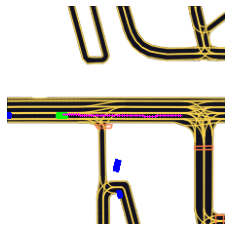

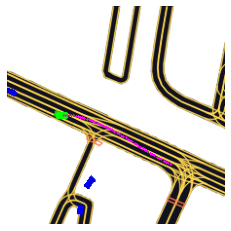

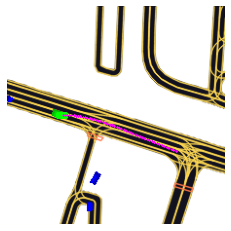

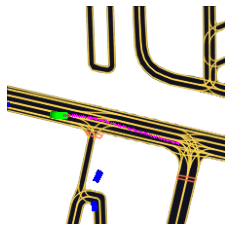

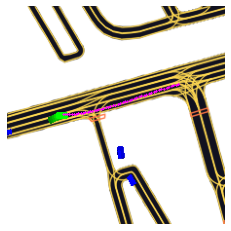

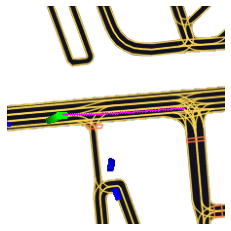

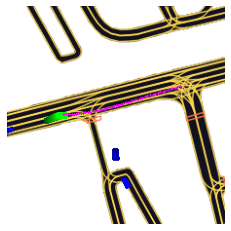

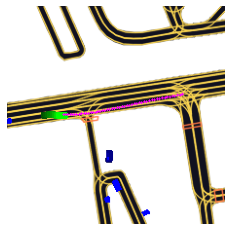

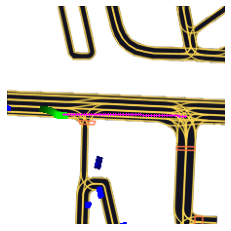

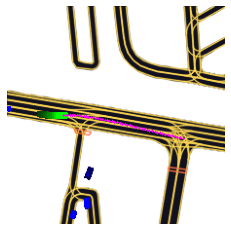

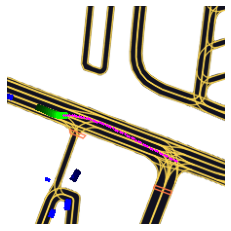

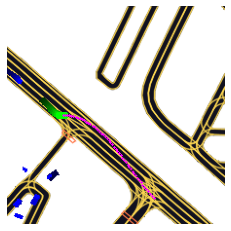

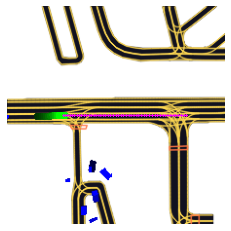

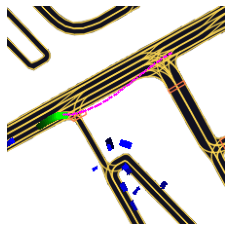

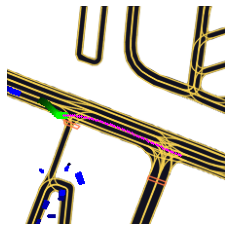

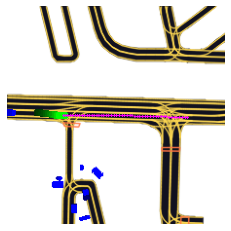

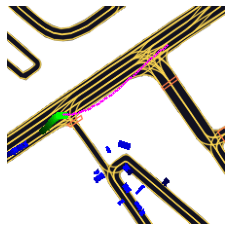

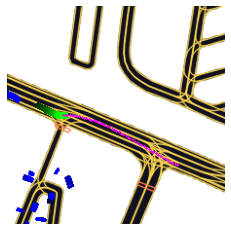

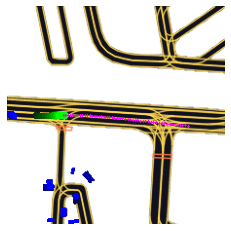

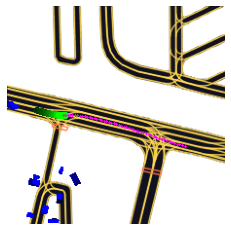

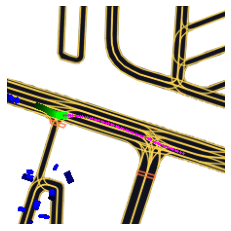

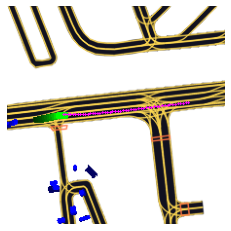

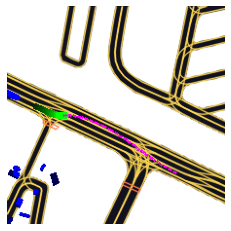

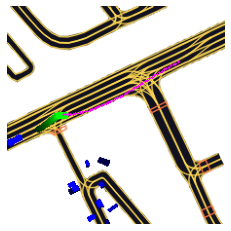

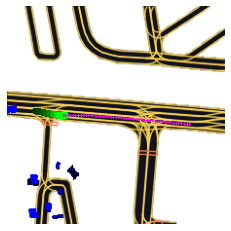

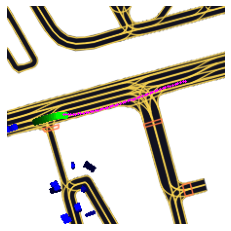

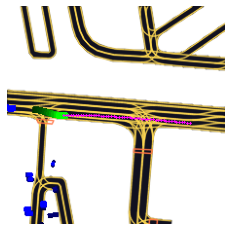

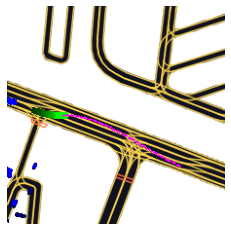

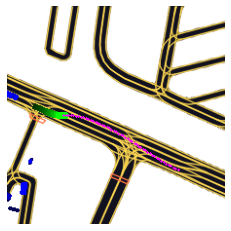

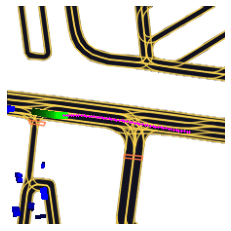

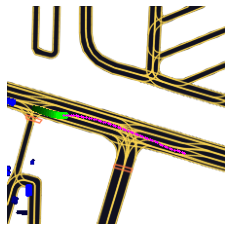

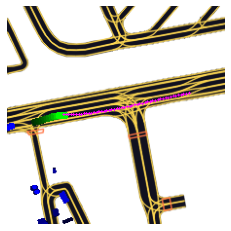

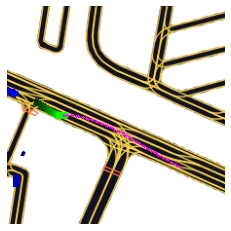

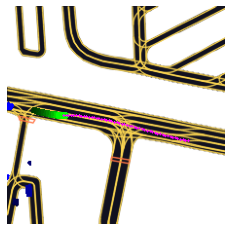

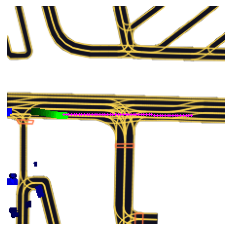

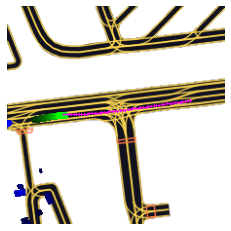

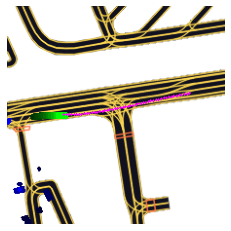

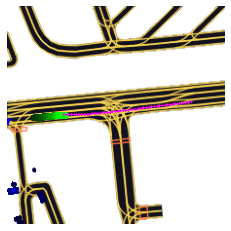

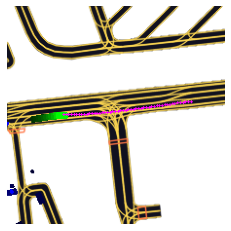

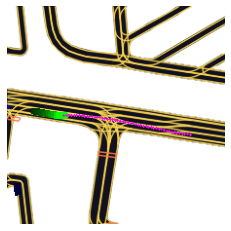

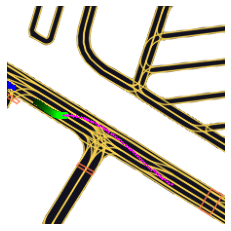

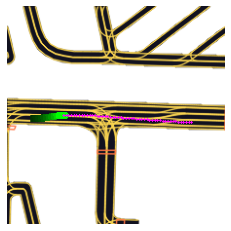

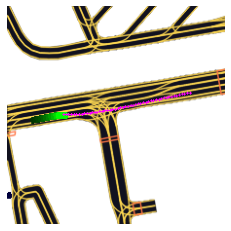

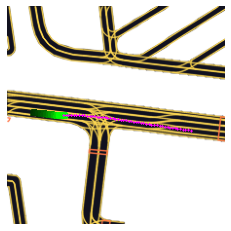

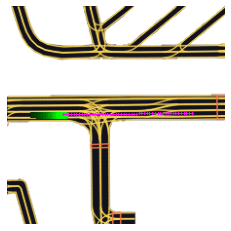

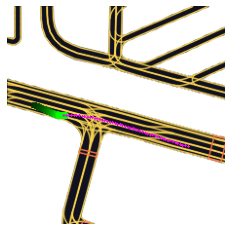

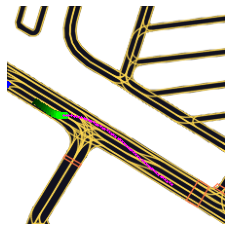

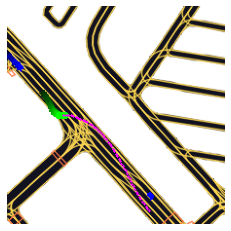

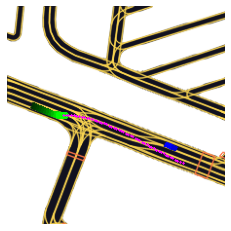

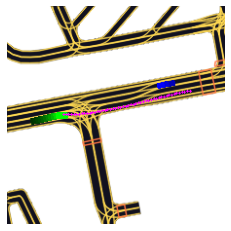

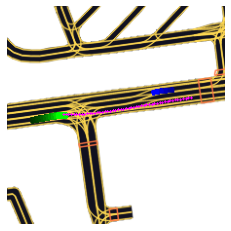

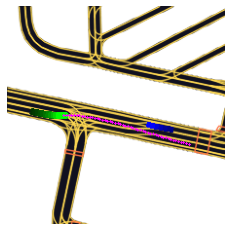

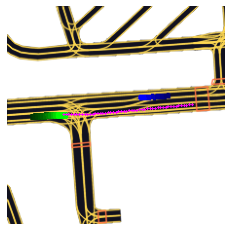

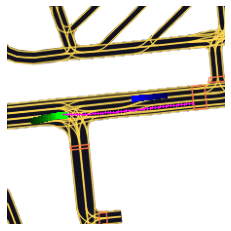

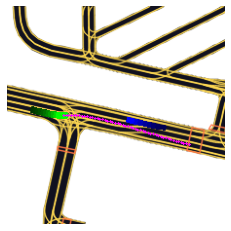

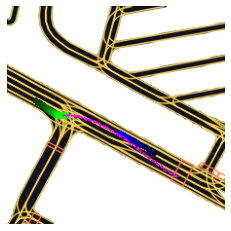

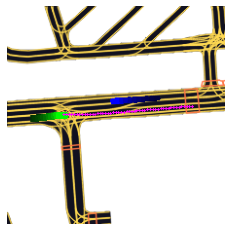

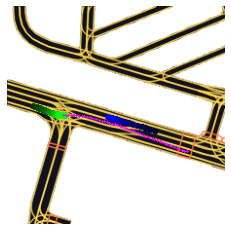

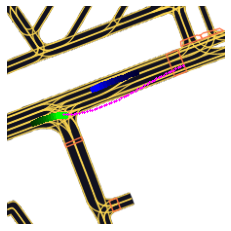

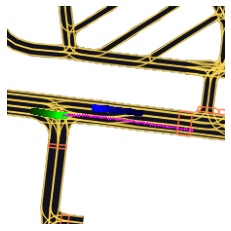

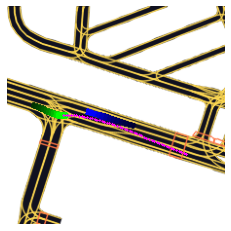

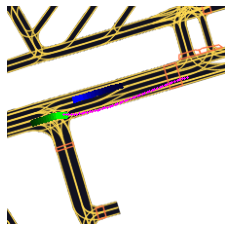

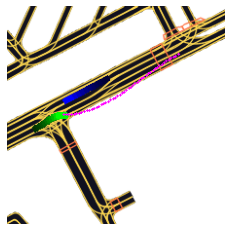

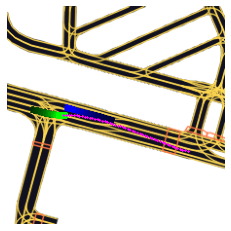

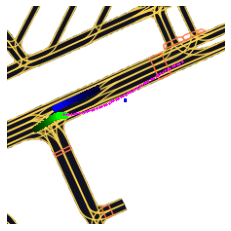

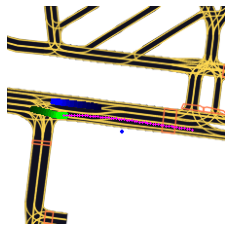

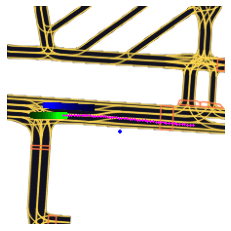

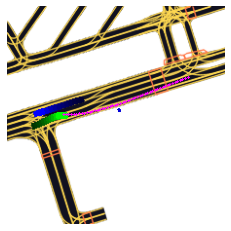

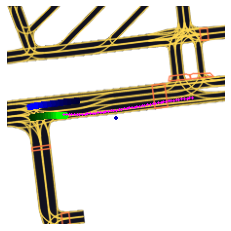

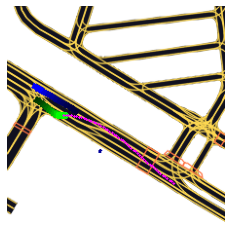

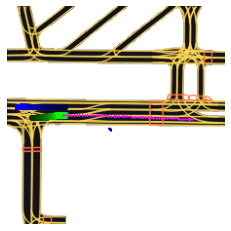

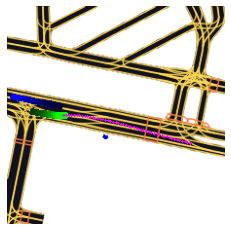

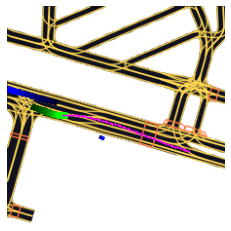

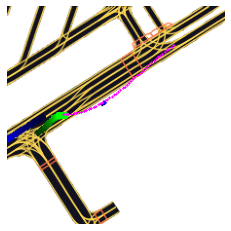

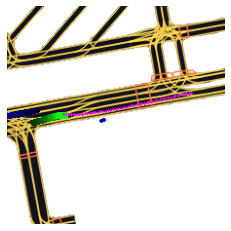

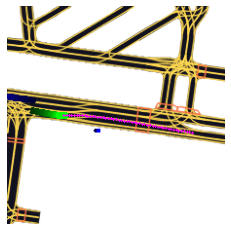

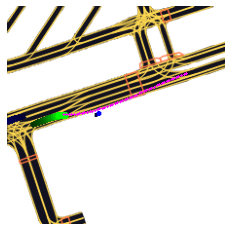

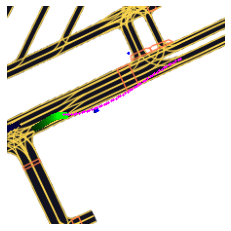

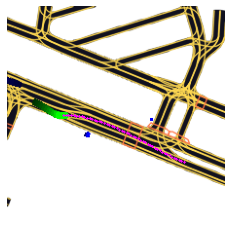

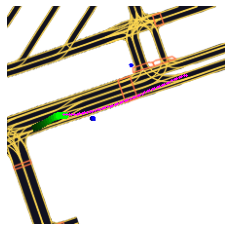

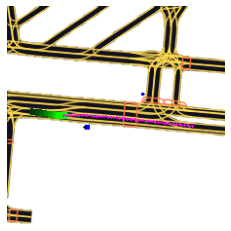

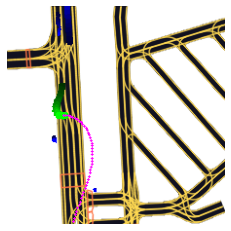

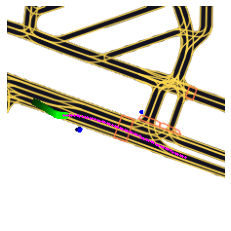

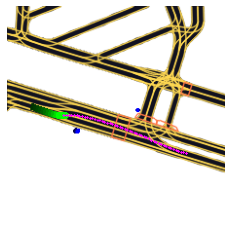

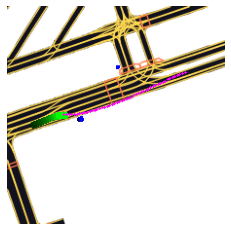

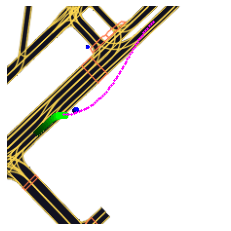

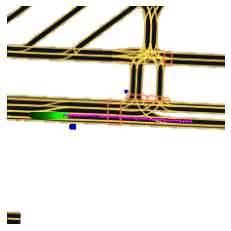

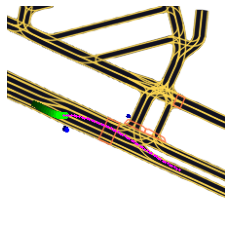

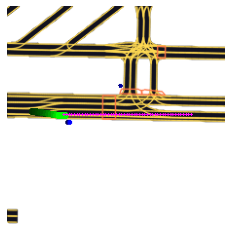

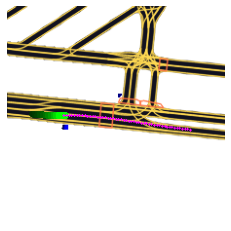

In [ ]:
# plot same example with and without perturbation
for perturbation_value in range(0,90):
    perturbation.perturb_prob = perturbation_value

    data_ego = train_dataset_2[perturbation_value]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    target_positions = transform_points(data_ego["target_positions"], data_ego["raster_from_agent"])
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    plt.imshow(im_ego)
    plt.axis('off')
    plt.show()

# before leaving, ensure perturb_prob is correct
perturbation.perturb_prob = perturb_prob

# Loss Function

In [ ]:
from torch import Tensor
def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

# Model

## Ensemble model

In [ ]:
!pip install timm
import timm
from timm.models.layers.conv2d_same import Conv2dSame
from utils.loss import pytorch_neg_multi_log_likelihood_batch
from utils.poolings import GeM

     |████████████████████████████████| 296kB 9.1MB/s 


ModuleNotFoundError: ignored

In [ ]:
class LMM(nn.Module):
    def __init__(self, model_architecture, H=30, gem=False):
        super().__init__()
        self.H = H
        num_history_channels = (self.H + 1) * 2
        rgb_channels = 6
        num_in_channels = rgb_channels + num_history_channels
        self.future_len = 50
        num_targets = 2 * self.future_len
        self.num_modes = 3
        self.num_preds = num_targets * self.num_modes
        self.backbone = timm.create_model(model_architecture, pretrained=False)

        if gem:
            self.backbone.global_pool = GeM()

        self.backbone.conv_stem = Conv2dSame(
            num_in_channels,
            self.backbone.conv_stem.out_channels,
            kernel_size=self.backbone.conv_stem.kernel_size,
            stride=self.backbone.conv_stem.stride,
            padding=self.backbone.conv_stem.padding,
            bias=False,
        )

        self.backbone_out_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(
            nn.Identity(),
            nn.Linear(
                in_features=self.backbone.classifier.in_features,
                out_features=self.backbone_out_features,
            ),
        )

        self.lin_head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(
                in_features=self.backbone_out_features,
                out_features=self.num_preds + self.num_modes,
            ),
        )

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, image_box, image_sat, image_sem, history, history_availabilities):
        x = torch.cat(
            (
                image_box[:, : self.H + 1].float(),
                image_box[:, 31 : 31 + self.H + 1].float(),
                image_sat,
                image_sem,
            ),
            1,
        )
        x = self.backbone(x)
        x = self.lin_head(x)
        return x

## Original

In [ ]:
class Model(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()
        
        architecture = cfg["model_params"]["model_architecture"]
        backbone = eval(architecture)(pretrained=True, progress=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2

        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Sequential(
            nn.Conv2d(
                num_in_channels, 
                self.backbone.conv1.out_channels, 
                kernel_size=self.backbone.conv1.kernel_size,
                stride=self.backbone.conv1.stride,
                padding=self.backbone.conv1.padding,
                bias=False,
            ),
            nn.ReLU(), # Added ReLU
            nn.MaxPool2d(kernel_size=self.backbone.conv1.kernel_size), #Pooling layer
        )

        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        
        if architecture == "resnet50":
            backbone_out_features = 2048
        else:
            backbone_out_features = 512

        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features, out_features=4096),
        )
        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes
        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        x = self.logit(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [ ]:
def forward(data, model, device, criterion = pytorch_neg_multi_log_likelihood_batch):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    loss = criterion(targets, preds, confidences, target_availabilities)
    return loss, preds, confidences

# == Init Model ==

In [ ]:
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model(cfg)

#load weight if there is a pretrained model
weight_path = cfg["model_params"]["weight_path"]
if weight_path: #https://stackoverflow.com/questions/56369030/runtimeerror-attempting-to-deserialize-object-on-a-cuda-device
    torch.save(model.state_dict(),weight_path)
    model.load_state_dict(copy.deepcopy(torch.load(weight_path, device)))

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(f'device {device}')
# Added this to output our layers of the "pretrained"
from torchsummary import summary
summary(model, (25, 512,1024))

device cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 512]          78,400
              ReLU-2         [-1, 64, 256, 512]               0
         MaxPool2d-3           [-1, 64, 36, 73]               0
       BatchNorm2d-4           [-1, 64, 36, 73]             128
              ReLU-5           [-1, 64, 36, 73]               0
         MaxPool2d-6           [-1, 64, 18, 37]               0
            Conv2d-7           [-1, 64, 18, 37]           4,096
       BatchNorm2d-8           [-1, 64, 18, 37]             128
              ReLU-9           [-1, 64, 18, 37]               0
           Conv2d-10           [-1, 64, 18, 37]          36,864
      BatchNorm2d-11           [-1, 64, 18, 37]             128
             ReLU-12           [-1, 64, 18, 37]               0
           Conv2d-13          [-1, 256, 18, 37]          16,384
      BatchNorm2d-14     

# == Train Model ==

In [ ]:
tr_it = iter(train_dataloader_2)

# progress bar for command line
progress = tqdm(range(cfg["train_params"]["max_num_steps"]))

# ## progress bar for google colab
# progress = tq.tqdm(range(cfg["train_params"]["max_num_steps"]))

torch.set_grad_enabled(False)
#############################################################
# using this to prevent error not sure what this list or array should be
# Metrics otherwise
losses_train = []
iterations = []
metrics = []
times = []
start = time.time()
model_name = cfg["model_params"]["model_name"]
#############################################################
for i in progress:    
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader_2)
        data = next(tr_it)

    model.train()
    torch.set_grad_enabled(True)
    loss, *_ = forward(data, model, device)
    """
    Error: AssertionError: confidences should sum to 1
    The error appeared because the model puts in somecases NaN values out, which resulted to AssertionError: confidences should sum to 1.
    This issue is also known under the term Exploding Gradient
    https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/discussion/187773
    """
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), 1)

    optimizer.step()

    losses_train.append(loss.item())
    ## We'll gather metrics every even step
    if i % cfg['train_params']['checkpoint_every_n_steps'] == 0:
        torch.save(model.state_dict(), f'{model_name}_{i}.pth')
        iterations.append(i)
        metrics.append(np.mean(losses_train))
        times.append((time.time()-start)/60)









  0%|          | 0/1000 [00:00<?, ?it/s]







  0%|          | 1/1000 [00:09<2:44:24,  9.87s/it]







  0%|          | 2/1000 [00:10<1:55:34,  6.95s/it]







  0%|          | 3/1000 [00:10<1:22:27,  4.96s/it]







  0%|          | 4/1000 [00:10<59:00,  3.55s/it]  







  0%|          | 5/1000 [00:16<1:12:34,  4.38s/it]







  1%|          | 6/1000 [00:17<51:43,  3.12s/it]  







  1%|          | 7/1000 [00:17<36:57,  2.23s/it]







  1%|          | 8/1000 [00:17<26:25,  1.60s/it]







  1%|          | 9/1000 [00:23<48:05,  2.91s/it]







  1%|          | 10/1000 [00:23<35:03,  2.12s/it]







  1%|          | 11/1000 [00:24<26:27,  1.61s/it]







  1%|          | 12/1000 [00:24<20:31,  1.25s/it]







  1%|▏         | 13/1000 [00:29<37:52,  2.30s/it]







  2%|▏         | 15/1000 [00:29<26:53,  1.64s/it]







  2%|▏         | 17/1000 [00:34<30:41,  1.87s/it]







  2%|▏         | 18/1000 [00:34<22:38,  1.38s/it]







  2%|▏         | 19/1000 [00:

AssertionError: ignored

# Plot and save model

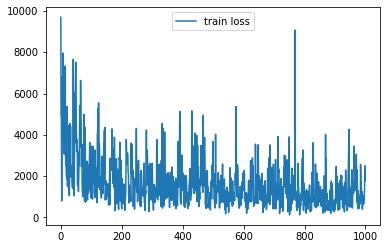

MODEL STORED at ./planning_model.pt


In [ ]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.savefig("pre_results.png")
plt.show()
#############################################################
to_save = torch.jit.script(model.cpu())
path_to_save = "/content/drive/MyDrive/lyft-motion-prediction-autonomous-vehicles/models/planning_model2.pt"
to_save.save(path_to_save)
print(f"MODEL STORED at {path_to_save}")
#############################################################
# Allow is to have better idea of the overall standing of the training
progress.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
results = pd.DataFrame({'iterations': iterations, 'metrics (avg)': metrics, 'elapsed_time (mins)': times})
results.to_csv(f"train_metrics_{model_name}_{num_iter}.csv", index = False)
print(f"Total training time is {(time.time()-start)/60} mins")
print(results.head())